In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import KFold,StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from itertools import cycle
from sklearn.model_selection import learning_curve
from scipy import interp

from Data_helper import LoadData, LoadDataEE

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#### 1- Plot the time step distribution of 48h, 72h, 96h and 120h

In [2]:
T_LENGTH = [48, 72, 96, 120]
OUTPUT_PATH = './output/phase_viii'
DATA_PATH = './data/phase_viii'

len_dict = {}
for t in T_LENGTH:
    DATA_PATH_SUBDIR = os.path.join(DATA_PATH, '{}hours'.format(t), 'processed', 'raw', 'data4hc_v20220401', 'data.npz')
    tsdata = np.load(DATA_PATH_SUBDIR, allow_pickle=True)

    t_length = []
    for i in range(tsdata['input'].shape[0]):
        t_length.append(tsdata['input'][i].shape[0])
    # result = Counter(t_length)
    len_dict[t] = t_length

    print("The {}-hours have been processed!".format(str(t)))

np.save(os.path.join(OUTPUT_PATH, 'time_step_distribution.npy'), len_dict)

The 48-hours have been processed!
The 72-hours have been processed!
The 96-hours have been processed!
The 120-hours have been processed!


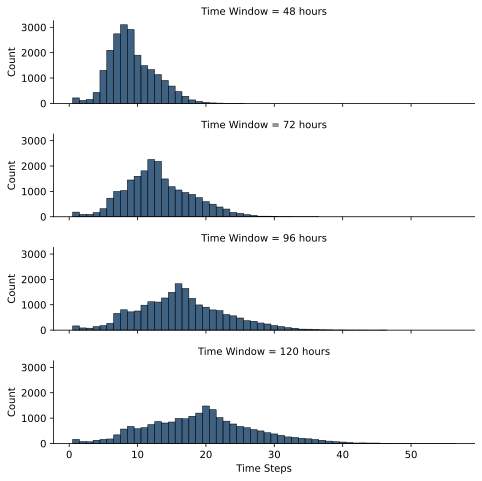

In [3]:
# plot bar based on seaborn
OUTPUT_PATH = './output/phase_viii'
DATA_PATH = './data/phase_viii'
len_dict = np.load('./output/phase_viii/time_step_distribution.npy', allow_pickle=True).tolist()
# transform the dict into dataframe
df = pd.DataFrame([], columns=['Time Window', 'Time Steps'])
for key, value in len_dict.items():
    df_r = pd.DataFrame(value, columns=['Time Steps'])
    df_r['Time Window'] = str(key) + ' hours'
    df = pd.concat([df, df_r], axis=0)

# adjust the font
# rc = {'font.sans-serif': ['Arial']}
# sns.set(context='notebook', style='ticks', rc=rc)  #  
# print(plt.rcParams['font.sans-serif'])

# plot
ordered_subplots = ['48 hours', '72 hours', '96 hours', '120 hours']
g = sns.FacetGrid(df, row="Time Window", row_order=ordered_subplots,
                  height=1.7, aspect=4)
g.map(sns.histplot, "Time Steps", linewidth=0.5, discrete=True, color='#012E58')  #, color='#3A3FC7' #2E3192
g.savefig("./timesteps.png", dpi=600)

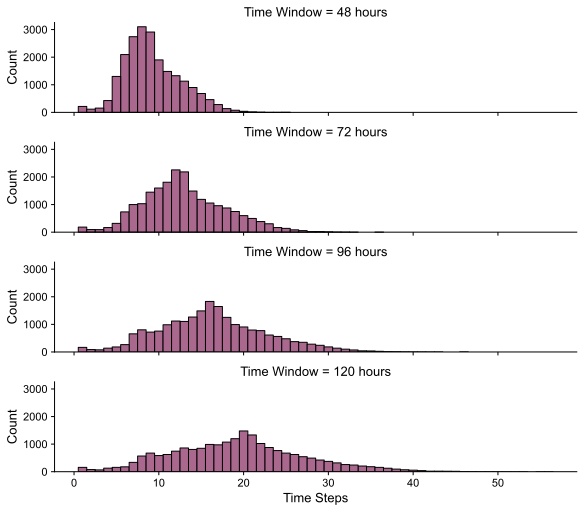

In [5]:
# plot the bar with plt.bar
OUTPUT_PATH = './output/phase_viii'
DATA_PATH = './data/phase_viii'
len_dict = np.load('./output/phase_viii/time_step_distribution.npy', allow_pickle=True).tolist()
data = {}
for key, value in len_dict.items():
    result = Counter(value)
    data[key] = result

all = pd.DataFrame([], columns=['Time Window', 'Time Steps', 'Count'])
for key, value in data.items():
    df = pd.DataFrame.from_dict(value, orient='index',columns=['Count'])
    df = df.reset_index().rename(columns = {'index':'Time Steps'})
    df['Time Window'] = str(key) + ' hours'
    all = pd.concat([all, df], axis=0)

plt.rc('font',family='Arial', size=11)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True, figsize=(8,7), constrained_layout=True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.bar(x=all[all['Time Window']=='48 hours']['Time Steps'], 
        height=all[all['Time Window']=='48 hours']['Count'], 
        width=1,
        color='#AA688F', #012E58 3A5E6E #43c3b5 #2D1E3E
        linewidth = 1,
        edgecolor='black')
ax1.set_ylabel('Count', fontproperties="Arial", fontsize=13)
ax1.set_title('Time Window = 48 hours', fontproperties="Arial", fontsize=13)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['left'].set_linewidth(1)
ax1.tick_params(width=1)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.bar(x=all[all['Time Window']=='72 hours']['Time Steps'], 
        height=all[all['Time Window']=='72 hours']['Count'], 
        width=1,
        linewidth = 1,
        color='#AA688F',
        edgecolor='black')
ax2.set_ylabel('Count', fontproperties="Arial", fontsize=13)
ax2.set_title('Time Window = 72 hours', fontproperties="Arial", fontsize=13)
ax2.spines['bottom'].set_linewidth(1)
ax2.spines['left'].set_linewidth(1)
ax2.tick_params(width=1)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.bar(x=all[all['Time Window']=='96 hours']['Time Steps'], 
        height=all[all['Time Window']=='96 hours']['Count'], 
        width=1,
        linewidth = 1,
        color='#AA688F',
        edgecolor='black')
ax3.set_ylabel('Count', fontproperties="Arial", fontsize=13)
ax3.set_title('Time Window = 96 hours', fontproperties="Arial", fontsize=13)
ax3.spines['bottom'].set_linewidth(1)
ax3.spines['left'].set_linewidth(1)
ax3.tick_params(width=1)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.bar(x=all[all['Time Window']=='120 hours']['Time Steps'], 
        height=all[all['Time Window']=='120 hours']['Count'], 
        width=1,
        linewidth = 1,
        color='#AA688F',
        edgecolor='black')
ax4.set_ylabel('Count', fontproperties="Arial", fontsize=13)
ax4.set_xlabel('Time Steps', fontproperties="Arial", fontsize=13)
ax4.set_title('Time Window = 120 hours', fontproperties="Arial", fontsize=13)
ax4.spines['bottom'].set_linewidth(1)
ax4.spines['left'].set_linewidth(1)
ax4.tick_params(width=1)

# plt.savefig(os.path.join(OUTPUT_PATH, 'Fig4_Distribution of timesteps.png'), dpi=600, bbox_inches='tight')

#### 2-Get the statistics of static features

In [3]:
# define the dict of english and chinese feature name
fdict = {
    'Age': 'visit_age',
    'Gender': 'gender',
    'Weight': 'weight',
    'Height': 'height',
    'Day of Visit': 'visit_day',
    'Month of Visit': 'visit_month',
    'Year of Visit': 'visit_year',
    'Smoking Habit': '吸烟习惯',
    'Education': '学历',
    'Profession': '职业',
    'Drinking Habit': '饮酒习惯',
    'Marital Status': '婚姻状况',
    'Previous Constitution': '既往体质',
    'Trauma History': '外伤史',
    'History of Heart Disease': '心脏病史',
    'Surgical History': '手术史',
    'History of Diabetes': '糖尿病史',
    'History of Tuberculosis': '肺结核史',
    'History of Kidney Disease': '肾病史',
    'History of Blood Transfusion': '输血史',
    'Long-term Medication History': '长期用药史',
    'History of High Blood Pressure': '高血压史',
    'Residence History in the Epidemic Area': '疫区居留史',
    'History of Exposure to Toxic and Radioactive Substances': '毒性及放射性物质接触史',
    'History of Travel': '冶游史',
    'Fatigue': '乏力',
    'Fever': '发热',
    'Difficult Breathing': '呼吸困难',
    'Cough': '咳嗽',
    'Expectoration': '咳痰',
    'Headache': '头痛',
    'Chills': '畏寒',
    'Chest Distress': '胸闷',
    'Fever Frequency': '发热-频次',
    'Fever Duration': '发热-时长',
    'Maximum Body Temperature': '最高体温',
    'Indigestion of Food': '大便-不消化食物',  # 粪便常规
    'Traits': '大便-性状',
    'White Blood Cells(WBCs)': '大便-白细胞',
    'Red Blood Cells(RBCs)': '大便-红细胞',
    'Pus Cells': '大便-脓细胞',
    'Occult Blood Test(OB)': '大便-隐血试验',
    'Color(colors)': '大便-颜色（大便）',
    'Nitrite(NIT)': '尿液-亚硝酸盐',    # 尿常规
    'Urobilinogen(UBG)': '尿液-尿胆原',
    'Turbidity(turbid)': '尿液-浊度',
    'Leukocyte Esterase(LEU)': '尿液-白细胞酯酶',
    'Bilirubin(BIL)': '尿液-胆红素',
    'Glucose(GLU)': '尿液-葡萄糖',
    'Protein(Pro)': '尿液-蛋白质',
    'Ketone Bodies(KET)': '尿液-酮体',
    'Occult Blood(BLD)': '尿液-隐血',
    'Color(Color)': '尿液-颜色',
    'pH(pH)': '尿液-pH值',
    'Epithelial Cells(ECU)': '尿液-上皮细胞',
    'Small Round Epithelial Cells(SRCU)': '尿液-小圆上皮细胞',
    'Specific Gravity(SG)': '尿液-比重',
    'Conductivity(CONDU)': '尿液-电导率',
    'Pathological Cast(P.CASTU)': '尿液-病理管型',
    'White Blood Cells(WBCU)': '尿液-白细胞',
    'Cast(CASTU)': '尿液-管型',
    'Yeast Like Colony(YLCU)': '尿液-类酵母菌',
    'Red Blood Cells(RBCU)': '尿液-红细胞',
    'Bacteria(BACTU)': '尿液-细菌',
    'Crystallization(XTALU)': '尿液-结晶',
    'Neutrophil Percent(N_mp)': '血液-中性粒细胞(%)',   # 血常规 
    'Neutrophil Count(GRAN)': '血液-中性粒细胞.',
    'Monocytes Percent(M_mp)': '血液-单核细胞(%)',
    'Monocyte Count(MO#)': '血液-单核细胞.',
    'Lymphocyte Percent(L_mp)': '血液-淋巴细胞(%)',
    'Lymphocyte Count(LYM)': '血液-淋巴细胞.',
    'Basophil Percent(B_mp)': '血液-嗜碱性粒细胞(%)',
    'Basophil Count(BA#)': '血液-嗜碱性粒细胞.',
    'Eosinophil Percent(E_mp)': '血液-嗜酸性粒细胞(%)',
    'Eosinophil Count(EO#)': '血液-嗜酸性粒细胞.',
    'White Blood Cell Count(WBC)': '血液-白细胞计数',
    'Red Blood Cell Count(RBC)': '血液-红细胞计数',
    'Mean Corpuscular Volume(MCV)': '血液-平均红细胞体积',
    'Red Blood Cell Distribution Width(RDW)': '血液-红细胞分布宽度',
    'Hematocrit(HCT)': '血液-红细胞压积',
    'Platelet Distribution Width(PDW)': '血液-血小板分布宽度',
    'Thrombocytocrit(PCT)': '血液-血小板压积',
    'Platelet Count(PLT)': '血液-血小板计数',
    'Mean Platelet Volume(MPV)': '血液-平均血小板体积',
    'Mean Corpuscular Hemoglobin(MCH)': '血液-平均血红蛋白含量',
    'Mean Corpuscular Hemoglobin Concentration(MCHC)': '血液-平均血红蛋白浓度',
    'Hemoglobin(HGB)': '血液-血红蛋白',
    'Calcium(Ca)': '血液-总钙',  # 肝肾脂糖电解质测定
    'Total Cholesterol(Tch)': '血液-总胆固醇',
    'Total Bile Acid(TBA)': '血液-总胆汁酸',
    'Total Bilirubin(TB)': '血液-总胆红素',
    'Direct Bilirubin(DB)': '血液-直接胆红素',
    'Indirect Bilirubin(IB)': '血液-间接胆红素',
    'Total Protein(TP)': '血液-总蛋白',
    'Low Density Lipoprotein C(LDL-ch)': '血液-低密度脂蛋白-C',
    'Very Low Density Lipoprotein C(VLDLC)': '血液-极低密度脂蛋白-C',
    'High Density Lipoprotein C(HDLc)': '血液-高密度脂蛋白-C',
    'Globulin(GloB)': '血液-球蛋白',
    'Albumin(Alb)': '血液-白蛋白',
    'Albumin/Globulin Ration(A/G)': '血液-白球蛋白比例',
    'Blood Urea Nitrogen(BUN)': '血液-尿素',
    'Blood Urea Nitrogen/Creatinine(BUN/Cr)': '血液-尿素氮/肌酐',
    'Uric Acid(UA)': '血液-尿酸',
    'Creatinine(Cr)': '血液-肌酐',
    'Inorganic Phosphorus(P)': '血液-无机磷',
    'Hemolysis Degree of Specimen(H)': '血液-标本溶血程度',
    'Turbidity Degree of Specimen(L)': '血液-标本脂浊程度',
    'Jaundice Degree of specimen(I)': '血液-标本黄疸程度',
    'Kalium(K)': '血液-钾',
    'Sodium(Na)': '血液-钠',
    'Chlorine(Cl)': '血液-氯',
    'Triglyceride(TG)': '血液-甘油三酯',
    'Glycyrrhizin Dipeptide Aminopeptidase(GPDA)': '血液-甘脯二肽氨基肽酶',
    'Alkaline Phosphatase(ALP)': '血液-碱性磷酸酶',
    'Cholinesterase(ChE)': '血液-胆碱酯酶',
    'Adenylic Deaminase(ADA)': '血液-腺苷酸脱氨酶',
    'Alanine Transaminase(ALT)': '血液-谷丙转氨酶',
    'Glutamic Oxalacetic Transaminase(AST)': '血液-谷草转氨酶',
    'Glutamylphthalase(GGT)': '血液-谷氨酰转酞酶',
    'ASTLT(ASTLT)': '血液-谷草谷丙比值',
    'α-Fucosidase(AFU)': '血液-α-岩藻糖苷酶',
    'Glomerular Filtration Rate(Cys)': '血液-肾小球滤过率(EPI-cys)',
    'Glomerular Filtration Rate(Cr-cys)': '血液-肾小球滤过率(EPI-cr-cys)',
    'Glomerular Filtration Rate(EPI-cr)': '血液-肾小球滤过率(EPI-cr)',
    'Lactic Dehydrogenase(LDH)': '血液-乳酸脱氢酶',  # 心肌酶谱常规检查
    'Creatine Phosphate Kinase(CK)': '血液-磷酸肌酸激酶',
    'Hydroxybutyrate Dehydrogenase(HBDH)': '血液-羟丁酸脱氢酶',
    'Creatine Kinase MB(CKMB)': '血液-肌酸激酶同工酶',
    'Free Fatty Acid(FFA)': '血液-游离脂肪酸',  # CYC+Hcy+FFA
    'Fasting Blood-glucose(Glu)': '血液-空腹血糖',
    'Cystatin C(CYC)': '血液-胱抑素C',
    'Homocysteine(Hcy)': '血液-同型半胱氨酸',
    'Total Thyroxine(TT4)': '血清-总甲状腺素',   # TT3、TT4、TSH、FT3、FT4、TPOAb
    'Free Triiodothyronine(FT3)': '血清-游离三碘甲状腺原氨酸',
    'Free Thyroxine(FT4)': '血清-游离甲状腺素',
    'Total Triiodothyronine(TT3)': '血清-总三碘甲状腺原氨酸',
    'Thyroid Peroxidase Antibody(aTPO)': '血清-甲状腺过氧化物酶抗体',
    'Rheumatoid Factors(RF)': '血液-类风湿因子',     # ASO+RF+超敏CRP
    'Antistreptolysin(ASO)': '血液-抗链球菌溶血素“O”',
    'C-reactive Protein(CRP)': '血液-C反应蛋白',
    'Fibrinogen(Fib)': '血浆-纤维蛋白原',   # 凝血功能常规检查
    'International Normalized Ratio(INR)': '血浆-国际标准化比值',
    'Thrombin Time(TT)': '血浆-凝血酶时间',
    'Prothrombin Time(PT(YQ))': '血浆-凝血酶原时间',
    'Activated Partial Thromboplastin Time(APTT)': '血浆-活化部分凝血活酶时间',
    'R-APTT(R-APTT)': '血浆-APTT对照',
    'Alpha Fetoprotein(AFP)': '血液-甲胎蛋白',  # 肿瘤标志物＋CA125+铁蛋白＋PSA（男）
    'Carcino-Embryonic Antigen(CEA)': '血液-癌胚抗原',
    'Ferritin(Ferritin)': '血液-铁蛋白',
    'Sugar Antigen 125(CA125Ⅱ)': '血液-糖抗原125',
    'Sugar Antigen 199(CA199 XR)': '血液-糖抗原199',
    'Treponema Pallidum Antibody(TP)': '血液-梅毒螺旋体抗体',  # 常规HBsAg、HCVAb、HIV、TP检查(自费)
    'Hepatitis B Surface Antigen(HBsAg)': '血液-乙肝表面抗原',
    'Hepatitis C Antibody IgG(Anti-HCV)': '血液-丙肝抗体IgG',
    'Erythrocyte Sedimentation Rate(ESR)': '血液-血沉',  #  红细胞沉降率测定(ESR)（病房）
    'Procalcitonin(PCT)': '血液-降钙素原',  # 降钙素原测定
    'Hypersensitive C-Reactive Protein(CRPH)': '血液-超敏C反应蛋白',  #  超敏C反应蛋白测定
    'D-Dimer(D-Dimer)': '血浆-D-二聚体',  # 血浆D-二聚体测定(D-Dimer)
    'Rh Blood Type(Rh)': '血液-Rh(D)血型',  # ABO血型鉴定(急诊)+Rh血型鉴定（急诊）
    'ABO Blood Type(ABO)': '血液-ABO血型'
}
OUTPUT_PATH = './data/phase_viii/48hours'
np.save(os.path.join(OUTPUT_PATH, 'variable_name_translation.npy'), fdict)

In [7]:
OUTPUT_PATH = './output/phase_viii'
DATA_PATH = './data/phase_viii'

# load the data
vdict = np.load(os.path.join(DATA_PATH, '48hours', 'map_item_index.npy'), allow_pickle=True).tolist()
cat_map_dict = np.load(os.path.join(DATA_PATH, '48hours', 'catemappings.npy'), allow_pickle=True).tolist()
data = np.load(os.path.join(DATA_PATH, '48hours', 'processed', 'raw', 'data4hc_v20220401', 'data.npz'), allow_pickle=True)
fold = np.load(os.path.join(DATA_PATH, '48hours', 'processed', 'raw', 'data4hc_v20220401', 'fold.npz'), allow_pickle=True)

# extract the feature names
fname = []
for key, value in vdict.items():
    fname.append(key)

fname_cat = fname[:53]
fname_val = fname[53:58] + fname[88:] # exclude the statictics of temporal features

# get the index of train, validation and test
idx_train = fold['hy-0'][0][0]
idx_validation = fold['hy-0'][0][1]
idx_test = fold['hy-0'][0][2]

# get the all data without temporal features
data_val = np.concatenate([data['static_val'][:, :5], data['static_val'][:, 35:]], axis=1)
data_cat = data['static_cat']
print("The shape of static numeric data without time-series info is {}".format(data_val.shape))
print("The shape of static categorical data is {}".format(data_cat.shape))

# split the data into train, validation and test
data_val_trn = data_val[idx_train]
data_val_vld = data_val[idx_validation]
data_val_tes = data_val[idx_test]

data_cat_trn = data_cat[idx_train]
data_cat_vld = data_cat[idx_validation]
data_cat_tes = data_cat[idx_test]

The shape of static numeric data without time-series info is (21524, 107)
The shape of static categorical data is (21524, 53)


In [3]:
# calculate the mean and std of Age
age_mean_trn = np.nanmean(data_val_trn, axis=0)[1]
age_std_trn = np.nanstd(data_val_trn, axis=0)[1]

age_mean_vld = np.nanmean(data_val_vld, axis=0)[1]
age_std_vld = np.nanstd(data_val_vld, axis=0)[1]

age_mean_tes = np.nanmean(data_val_tes, axis=0)[1]
age_std_tes = np.nanstd(data_val_tes, axis=0)[1]
print("The mean(s.d.) of train, validation and test is {0}({1}), {2}({3}), {4}({5})".format(
    age_mean_trn, age_std_trn, age_mean_vld, age_std_vld, age_mean_tes, age_std_tes
))

The mean(s.d.) of train, validation and test is 52.85811360204437(18.3652276702801), 52.25731537389689(18.42645777571418), 52.37807710171853(18.317277106948048)


In [4]:
# calculate the distribution of Gender
dst_trn = Counter(data_cat_trn[:,0])
dst_vld = Counter(data_cat_vld[:,0])
dst_tes = Counter(data_cat_tes[:,0])

print("The Female, Male and ratio of train is {0}, {1}, {2}, {3}".format(dst_trn[0], dst_trn[1], dst_trn[0]/(dst_trn[0]+dst_trn[1]), dst_trn[1]/(dst_trn[0]+dst_trn[1])))
print("The Female, Male and ratio of validation is {0}, {1}, {2}, {3}".format(dst_vld[0], dst_vld[1], dst_vld[0]/(dst_vld[0]+dst_vld[1]), dst_vld[1]/(dst_vld[0]+dst_vld[1])))
print("The Female, Male and ratio of test is {0}, {1}, {2}, {3}".format(dst_tes[0], dst_tes[1], dst_tes[0]/(dst_tes[0]+dst_tes[1]), dst_tes[1]/(dst_tes[0]+dst_tes[1])))

The Female, Male and ratio of train is 9571, 7647, 0.5558717621094204, 0.44412823789057965
The Female, Male and ratio of validation is 1230, 923, 0.571295866233163, 0.42870413376683697
The Female, Male and ratio of test is 1186, 967, 0.5508592661402694, 0.44914073385973063


In [67]:
# calculate the distribution of Label
label_mapping = {'1-1':'0', '1-2':'1', '1-3':'2', '2-1-1':'3', '2-1-2':'4', '2-2-1':'5', '2-2-2':'6'}
label_mapping_re = dict([value, key] for key, value in label_mapping.items())

label = data['label'][:, 0]
label = np.array([label_mapping_re[x] for x in label])
# Root(train|validation|test)
print("Root(train|validation|test) = {0}|{1}|{2}".format(len(label[idx_train]), len(label[idx_validation]), len(label[idx_test])))
# Root/Infectious disease(train|validation|test)
label_infec_trn = np.array([])
for i in label[idx_train]:
    if i in ['1-1', '1-2', '1-3']:
        label_infec_trn=np.append(label_infec_trn, i)
label_infec_vld = np.array([])
for i in label[idx_validation]:
    if i in ['1-1', '1-2', '1-3']:
        label_infec_vld=np.append(label_infec_vld, i)
label_infec_tes = np.array([])
for i in label[idx_test]:
    if i in ['1-1', '1-2', '1-3']:
        label_infec_tes=np.append(label_infec_tes, i)
print("Root/Infectious disease(train|validation|test) = {0}|{1}|{2}".format(len(label_infec_trn), len(label_infec_vld), len(label_infec_tes)))
# Root/Infectious disease/bacterial infection
label_bac_trn = np.array([])
for i in label_infec_trn:
    if i in ['1-1']:
        label_bac_trn=np.append(label_bac_trn, i)
label_bac_vld = np.array([])
for i in label_infec_vld:
    if i in ['1-1']:
        label_bac_vld=np.append(label_bac_vld, i)
label_bac_tes = np.array([])
for i in label_infec_tes:
    if i in ['1-1']:
        label_bac_tes=np.append(label_bac_tes, i)
print("Root/Infectious disease/bacterial infection(train|validation|test) = {0}|{1}|{2}".format(len(label_bac_trn), len(label_bac_vld), len(label_bac_tes)))
# Root/Infectious disease/viral infection
label_vri_trn = np.array([])
for i in label_infec_trn:
    if i in ['1-2']:
        label_vri_trn=np.append(label_vri_trn, i)
label_vri_vld = np.array([])
for i in label_infec_vld:
    if i in ['1-2']:
        label_vri_vld=np.append(label_vri_vld, i)
label_vri_tes = np.array([])
for i in label_infec_tes:
    if i in ['1-2']:
        label_vri_tes=np.append(label_vri_tes, i)
print("Root/Infectious disease/viral infection(train|validation|test) = {0}|{1}|{2}".format(len(label_vri_trn), len(label_vri_vld), len(label_vri_tes)))
# Root/Infectious disease/fungal infection
label_fun_trn = np.array([])
for i in label_infec_trn:
    if i in ['1-3']:
        label_fun_trn=np.append(label_fun_trn, i)
label_fun_vld = np.array([])
for i in label_infec_vld:
    if i in ['1-3']:
        label_fun_vld=np.append(label_fun_vld, i)
label_fun_tes = np.array([])
for i in label_infec_tes:
    if i in ['1-3']:
        label_fun_tes=np.append(label_fun_tes, i)
print("Root/Infectious disease/fungal infection(train|validation|test) = {0}|{1}|{2}".format(len(label_fun_trn), len(label_fun_vld), len(label_fun_tes)))
# Root/Noninfectious disease(train|validation|test)
label_noinfec_trn = np.array([])
for i in label[idx_train]:
    if i in ['2-1-1', '2-1-2', '2-2-1', '2-2-2']:
        label_noinfec_trn=np.append(label_noinfec_trn, i)
label_noinfec_vld = np.array([])
for i in label[idx_validation]:
    if i in ['2-1-1', '2-1-2', '2-2-1', '2-2-2']:
        label_noinfec_vld=np.append(label_noinfec_vld, i)
label_noinfec_tes = np.array([])
for i in label[idx_test]:
    if i in ['2-1-1', '2-1-2', '2-2-1', '2-2-2']:
        label_noinfec_tes=np.append(label_noinfec_tes, i)
print("Root/Noninfectious disease(train|validation|test) = {0}|{1}|{2}".format(len(label_noinfec_trn), len(label_noinfec_vld), len(label_noinfec_tes)))
# Root/Noninfectious disease/NIID(train|validation|test)
label_NIID_trn = np.array([])
for i in label[idx_train]:
    if i in ['2-1-1', '2-1-2']:
        label_NIID_trn=np.append(label_NIID_trn, i)
label_NIID_vld = np.array([])
for i in label[idx_validation]:
    if i in ['2-1-1', '2-1-2']:
        label_NIID_vld=np.append(label_NIID_vld, i)
label_NIID_tes = np.array([])
for i in label[idx_test]:
    if i in ['2-1-1', '2-1-2']:
        label_NIID_tes=np.append(label_NIID_tes, i)
print("Root/Noninfectious disease/NIID(train|validation|test) = {0}|{1}|{2}".format(len(label_NIID_trn), len(label_NIID_vld), len(label_NIID_tes)))
# Root/Noninfectious disease/NIID/AD(train|validation|test)
label_AD_trn = np.array([])
for i in label[idx_train]:
    if i in ['2-1-1']:
        label_AD_trn=np.append(label_AD_trn, i)
label_AD_vld = np.array([])
for i in label[idx_validation]:
    if i in ['2-1-1']:
        label_AD_vld=np.append(label_AD_vld, i)
label_AD_tes = np.array([])
for i in label[idx_test]:
    if i in ['2-1-1']:
        label_AD_tes=np.append(label_AD_tes, i)
print("Root/Noninfectious disease/NIID/AD(train|validation|test) = {0}|{1}|{2}".format(len(label_AD_trn), len(label_AD_vld), len(label_AD_tes)))
# Root/Noninfectious disease/NIID/AID(train|validation|test)
label_AID_trn = np.array([])
for i in label[idx_train]:
    if i in ['2-1-2']:
        label_AID_trn=np.append(label_AID_trn, i)
label_AID_vld = np.array([])
for i in label[idx_validation]:
    if i in ['2-1-2']:
        label_AID_vld=np.append(label_AID_vld, i)
label_AID_tes = np.array([])
for i in label[idx_test]:
    if i in ['2-1-2']:
        label_AID_tes=np.append(label_AID_tes, i)
print("Root/Noninfectious disease/NIID/AID(train|validation|test) = {0}|{1}|{2}".format(len(label_AID_trn), len(label_AID_vld), len(label_AID_tes)))
# Root/Noninfectious disease/neoplastic disease(train|validation|test)
label_neo_trn = np.array([])
for i in label[idx_train]:
    if i in ['2-2-1', '2-2-2']:
        label_neo_trn=np.append(label_neo_trn, i)
label_neo_vld = np.array([])
for i in label[idx_validation]:
    if i in ['2-2-1', '2-2-2']:
        label_neo_vld=np.append(label_neo_vld, i)
label_neo_tes = np.array([])
for i in label[idx_test]:
    if i in ['2-2-1', '2-2-2']:
        label_neo_tes=np.append(label_neo_tes, i)
print("Root/Noninfectious disease/neoplastic disease(train|validation|test) = {0}|{1}|{2}".format(len(label_neo_trn), len(label_neo_vld), len(label_neo_tes)))
# Root/Noninfectious disease/neoplastic disease/HM(train|validation|test)
label_hm_trn = np.array([])
for i in label[idx_train]:
    if i in ['2-2-1']:
        label_hm_trn=np.append(label_hm_trn, i)
label_hm_vld = np.array([])
for i in label[idx_validation]:
    if i in ['2-2-1']:
        label_hm_vld=np.append(label_hm_vld, i)
label_hm_tes = np.array([])
for i in label[idx_test]:
    if i in ['2-2-1']:
        label_hm_tes=np.append(label_hm_tes, i)
print("Root/Noninfectious disease/neoplastic disease/HM(train|validation|test) = {0}|{1}|{2}".format(len(label_hm_trn), len(label_hm_vld), len(label_hm_tes)))
# Root/Noninfectious disease/neoplastic disease/SM(train|validation|test)
label_sm_trn = np.array([])
for i in label[idx_train]:
    if i in ['2-2-2']:
        label_sm_trn=np.append(label_sm_trn, i)
label_sm_vld = np.array([])
for i in label[idx_validation]:
    if i in ['2-2-2']:
        label_sm_vld=np.append(label_sm_vld, i)
label_sm_tes = np.array([])
for i in label[idx_test]:
    if i in ['2-2-2']:
        label_sm_tes=np.append(label_sm_tes, i)
print("Root/Noninfectious disease/neoplastic disease/SM(train|validation|test) = {0}|{1}|{2}".format(len(label_sm_trn), len(label_sm_vld), len(label_sm_tes)))

Root(train|validation|test) = 17218|2153|2153
Root/Infectious disease(train|validation|test) = 12825|1604|1604
Root/Infectious disease/bacterial infection(train|validation|test) = 8987|1124|1124
Root/Infectious disease/viral infection(train|validation|test) = 3061|383|383
Root/Infectious disease/fungal infection(train|validation|test) = 777|97|97
Root/Noninfectious disease(train|validation|test) = 4393|549|549
Root/Noninfectious disease/NIID(train|validation|test) = 1853|231|231
Root/Noninfectious disease/NIID/AD(train|validation|test) = 1284|160|160
Root/Noninfectious disease/NIID/AID(train|validation|test) = 569|71|71
Root/Noninfectious disease/neoplastic disease(train|validation|test) = 2540|318|318
Root/Noninfectious disease/neoplastic disease/HM(train|validation|test) = 1211|152|152
Root/Noninfectious disease/neoplastic disease/SM(train|validation|test) = 1329|166|166


#### 3-Plot the boxplot of GRU-D models

In [2]:
# Prepare the data for boxplot
DATA_PATH = './test/phase_viii'
OUTPUT_PATH = './output/phase_viii'

TIME = [48, 72, 96, 120] # 120
LABEL_DICT = {'0': 'infectious and non-infectious', 
              '1': 'bacterial, viral and others', 
              '2': 'NIID and tumor', 
              '3': 'AD and AID', 
              '4': 'HM and SM'}

box_data = {}
for key, value in LABEL_DICT.items():
    sub_data = []
    if value == 'bacterial, viral and others':
        for t in TIME:
            path = os.path.join(DATA_PATH, '{}hours'.format(str(t)), '20220716', 'GRUD_PreAttenSpatial_7dim_{}hrs_Paper(optuna)'.format(str(t)), 'roc(test_bootstrap)({}).npy'.format(value))
            roc = np.load(path, allow_pickle=True).tolist()
            roc_arr = np.array([])
            for roc_key, roc_value in roc.items():
                roc_arr = np.append(roc_arr, roc_value['roc_auc']['macro'])
            sub_data.append(roc_arr)
    else:
        for t in TIME:
            path = os.path.join(DATA_PATH, '{}hours'.format(str(t)), '20220716', 'GRUD_PreAttenSpatial_7dim_{}hrs_Paper(optuna)'.format(str(t)), 'roc(test_bootstrap)({}).npy'.format(value))
            roc = np.load(path, allow_pickle=True).tolist()
            roc_arr = np.array([])
            for roc_key, roc_value in roc.items():
                roc_arr = np.append(roc_arr, roc_value['roc_auc'])
            sub_data.append(roc_arr)
    box_data[value] = sub_data

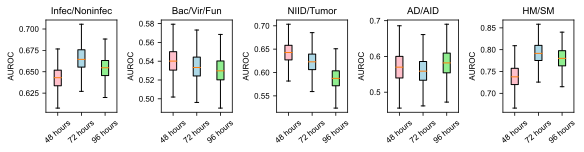

In [10]:
# Plot the boxplot by matplotlib
plt.rc('font',family='Arial', size=8)
LABELS = ['48 hours', '72 hours', '96 hours', '120 hours']
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(8,2), constrained_layout=True)
bplot1 = ax1.boxplot(box_data['infectious and non-infectious'],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     showfliers=False,
                     labels=LABELS)  # will be used to label x-ticks
ax1.tick_params(axis='x', rotation=40)
ax1.set_title('Infec/Noninfec')

bplot2 = ax2.boxplot(box_data['bacterial, viral and others'],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     showfliers=False,
                     labels=LABELS)  # will be used to label x-ticks
ax2.tick_params(axis='x', rotation=40)
ax2.set_title('Bac/Vir/Fun')

bplot3 = ax3.boxplot(box_data['NIID and tumor'],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     showfliers=False,
                     labels=LABELS)  # will be used to label x-ticks
ax3.tick_params(axis='x', rotation=40)
ax3.set_title('NIID/Tumor')

bplot4 = ax4.boxplot(box_data['AD and AID'],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     showfliers=False,
                     labels=LABELS)  # will be used to label x-ticks
ax4.tick_params(axis='x', rotation=40)
ax4.set_title('AD/AID')

bplot5 = ax5.boxplot(box_data['HM and SM'],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     showfliers=False,
                     labels=LABELS)  # will be used to label x-ticks
ax5.tick_params(axis='x', rotation=40)
ax5.set_title('HM/SM')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen', 'black', 'red']
for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2, ax3, ax4, ax5]:
    # ax.yaxis.grid(True)
    # ax.set_xlabel('The Length of Time window')
    ax.set_ylabel('AUROC')

plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

48 hours v.s. 72 hours: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.026e-279 U_stat=3.836e+04
48 hours v.s. 96 hours: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.781e-233 U_stat=7.844e+04
48 hours v.s. 120 hours: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.892e-202 U_stat=1.082e+05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

48 hours v.s. 72 hours: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.582e-47 U_stat=3.130e+05
48 hours v.s. 96 hours: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.665e-239 U_stat=7.322e+04
48 hours v.s. 120 hours: Mann-Whitney-Wilcoxon test two-s

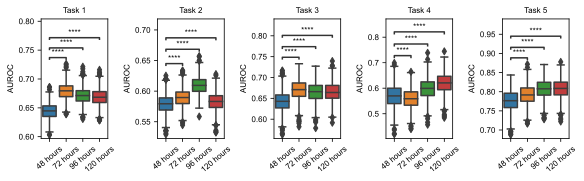

In [6]:
# Plot the boxplot by seaborn
plt.rc('font',family='Arial', size=8)
LABELS = ['48 hours', '72 hours', '96 hours', '120 hours']
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(8,2.4), constrained_layout=True)

df = pd.DataFrame(pd.DataFrame(box_data['infectious and non-infectious']).stack().unstack(0).rename(columns={0: '48 hours', 1: '72 hours', 2: '96 hours', 3: '120 hours'}).stack()).reset_index()
df = df.rename(columns={'level_0':'index', 'level_1':'TIME', 0:'AUROC'})
ax1 = sns.boxplot(data=df, x='TIME', y='AUROC', order=LABELS, ax=ax1)
add_stat_annotation(ax1, data=df, x='TIME', y='AUROC', order=LABELS,
                    box_pairs=[("48 hours", "72 hours"), ("48 hours", "96 hours"), ("48 hours", "120 hours")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)  # Mann-Whitney
ax1.tick_params(axis='x', rotation=40)
ax1.set_title('Task 1', fontproperties="Arial")
ax1.set_xlabel("")

df = pd.DataFrame(pd.DataFrame(box_data['bacterial, viral and others']).stack().unstack(0).rename(columns={0: '48 hours', 1: '72 hours', 2: '96 hours', 3: '120 hours'}).stack()).reset_index()
df = df.rename(columns={'level_0':'index', 'level_1':'TIME', 0:'AUROC'})
ax2 = sns.boxplot(data=df, x='TIME', y='AUROC', order=LABELS, ax=ax2)
add_stat_annotation(ax2, data=df, x='TIME', y='AUROC', order=LABELS,
                    box_pairs=[("48 hours", "72 hours"), ("48 hours", "96 hours"), ("48 hours", "120 hours")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
ax2.tick_params(axis='x', rotation=40)
ax2.set_title('Task 2', fontproperties="Arial")
ax2.set_xlabel("")

df = pd.DataFrame(pd.DataFrame(box_data['NIID and tumor']).stack().unstack(0).rename(columns={0: '48 hours', 1: '72 hours', 2: '96 hours', 3: '120 hours'}).stack()).reset_index()
df = df.rename(columns={'level_0':'index', 'level_1':'TIME', 0:'AUROC'})
ax3 = sns.boxplot(data=df, x='TIME', y='AUROC', order=LABELS, ax=ax3)
add_stat_annotation(ax3, data=df, x='TIME', y='AUROC', order=LABELS,
                    box_pairs=[("48 hours", "72 hours"), ("48 hours", "96 hours"), ("48 hours", "120 hours")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
ax3.tick_params(axis='x', rotation=40)
ax3.set_title('Task 3', fontproperties="Arial")
ax3.set_xlabel("")

df = pd.DataFrame(pd.DataFrame(box_data['AD and AID']).stack().unstack(0).rename(columns={0: '48 hours', 1: '72 hours', 2: '96 hours', 3: '120 hours'}).stack()).reset_index()
df = df.rename(columns={'level_0':'index', 'level_1':'TIME', 0:'AUROC'})
ax4 = sns.boxplot(data=df, x='TIME', y='AUROC', order=LABELS, ax=ax4)
add_stat_annotation(ax4, data=df, x='TIME', y='AUROC', order=LABELS,
                    box_pairs=[("48 hours", "72 hours"), ("48 hours", "96 hours"), ("48 hours", "120 hours")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
ax4.tick_params(axis='x', rotation=40)
ax4.set_title('Task 4', fontproperties="Arial")
ax4.set_xlabel("")

df = pd.DataFrame(pd.DataFrame(box_data['HM and SM']).stack().unstack(0).rename(columns={0: '48 hours', 1: '72 hours', 2: '96 hours', 3: '120 hours'}).stack()).reset_index()
df = df.rename(columns={'level_0':'index', 'level_1':'TIME', 0:'AUROC'})
ax5 = sns.boxplot(data=df, x='TIME', y='AUROC', order=LABELS, ax=ax5)
add_stat_annotation(ax5, data=df, x='TIME', y='AUROC', order=LABELS,
                    box_pairs=[("48 hours", "72 hours"), ("48 hours", "96 hours"), ("48 hours", "120 hours")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
ax5.tick_params(axis='x', rotation=40)
ax5.set_title('Task 5', fontproperties="Arial")
ax5.set_xlabel("")

plt.savefig(os.path.join(OUTPUT_PATH, 'Fig6_AUROC_of_GRU-D_Paper.png'), dpi=600, bbox_inches='tight')

In [ ]:
for key, value in len_dict.items():
    
    df = pd.DataFrame.from_dict(value, orient='index',columns=['counts'])
    df = df.reset_index().rename(columns = {'index':'length'})

    plt.figure(figsize=(30,15))
    p1 = plt.bar(df['length'], df['counts'], label='{}hours'.format(str(key).title()))
    for a, b in zip(df['length'], df['counts']):
        plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
    plt.title('The time length distribution in {0}hours time-series data'.format(str(key).title()))
    plt.xlabel('The observation times')
    plt.ylabel('The number of observation')
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_PATH, '{}hours'.format(key), 'Distribution_of_time_length({0}hours).png'.format(str(key))), bbox_inches='tight')
    plt.show()
    plt.close()

[info] The 0th round is processing


/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


[info] The 1th round is processing


/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


[info] The 2th round is processing


/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


[info] The 3th round is processing


/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


[info] The 4th round is processing


/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


[info] The 5th round is processing


/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


[info] The 6th round is processing


/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


[info] The 7th round is processing


/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


[info] The 8th round is processing


/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


[info] The 9th round is processing


/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


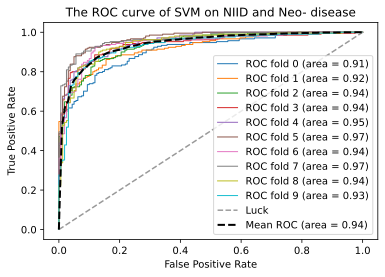

In [5]:
"""
Plot the ROC curve for DNN model
"""
ld = LoadData('fuo', 'label4visit')
X_train_YL1, y_train_YL1, X_train_YL21, y_train_YL21, X_train_YL22, y_train_YL22, X_train_YL31, y_train_YL31, X_train_YL32, y_train_YL32, X_test, y_test = ld.splitData()
print("=======================================================")
print("Loading Data is Done!")
print("=======================================================")

# 10 fold cross-validation and SVM (optional)
cv = StratifiedKFold(n_splits=10)
model = tf.keras.models.load_model('/mnt/data/wzx/jupyter_notebook/HC4FUO/model_dl/model4L22_sparse_loss.h5')

# Classification and ROC analysis
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
i = 0
for train, test in cv.split(X_train_YL22, y_train_YL22):
    print("[info] The {}th round is processing".format(i))
    # y_train = to_categorical(y_train_YL22[train], num_classes=None)
    # y_test = to_categorical(y_train_YL22[test], num_classes=None)
    # model.fit(X_train_YL22[train], y_train_YL22[train])
    # model.summary()
    y_pred_keras = model.predict(X_train_YL22[test])[:,1]

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train_YL22[test], y_pred_keras)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= 10
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC curve of SVM on NIID and Neo- disease')
plt.legend(loc="lower right")
# plt.savefig("./model2/20210915-ROC-gbm.png",dpi=400)
plt.show()

In [3]:
"""
Plot ROC curve for DNN_EE model
"""
def preprocessing(data, col_range_cat):
    # convert the dataframe data into nn format
    X = []
    for i in range(col_range_cat[1]):
        X_cat = data[...,[i]]
        X.append(X_cat)
    X_val = data[..., col_range_cat[1]:]
    X.append(X_val)

    return X

ld = LoadDataEE('fuo', 'label4visit')
X_train_YL1, y_train_YL1, X_train_YL21, y_train_YL21, X_train_YL22, y_train_YL22, X_train_YL31, y_train_YL31, X_train_YL32, y_train_YL32, X_test, y_test, col_range_cat, col_range_val, embedding_size = ld.splitDataEE()
print("=======================================================")
print("Loading Data is Done!")
print("=======================================================")

# 10 fold cross-validation and SVM (optional)
cv = StratifiedKFold(n_splits=10)
model = tf.keras.models.load_model('/mnt/data/wzx/jupyter_notebook/HC4FUO/model_dl/DNN_EE/model4L1.h5')

# Classification and ROC analysis
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
i = 0
for train, test in cv.split(X_train_YL1, y_train_YL1):
    print("[info] The {}th round is processing".format(i))
    y_pred_keras = model.predict(preprocessing(X_train_YL1[test], col_range_cat))[:,1]

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train_YL1[test], y_pred_keras)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= 10
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC curve of SVM on NIID and Neo- disease')
plt.legend(loc="lower right")
# plt.savefig("./model2/20210915-ROC-gbm.png",dpi=400)
plt.show()

The shape of original label is (29966, 7)
The distribution of visit of YL1 is [25333  4633]
The distribution of visit of YL2-1 is [19111  4283  1939]
The distribution of visit of YL2-2 is [2007 2626]
The distribution of visit of YL3-1 is [1418  589]
The distribution of visit of YL3-2 is [1446 1180]


/home/zju/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (22,24,25,26,28,29,32,45,46,47,49,50,51,52,53,54,55,56,57,58,66,67,69,70,71,72,75,77,78,82,83,84,87,88,94,95,96,97,102,103,104,105,110,115,116,119,121,122,123,124,126,128,133) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The shape of original data_val is (33636, 133)
The shape of original data_cat is (33636, 54)
The shape of X_train is (23972, 185)
The shape of X_test is (5994, 185)
The distribution of visit of y_train_YL22 is [1605 2101]
The distribution of visit of y_train_YL32 is [1157  944]
Loading Data is Done!
[info] The 0th round is processing


ValueError: unknown format is not supported